
## Project Description

Modern deep learning hinges on variants of stochastic gradient descent. Give an overview of some of the algorithms (ADAM,
RMSProp, Adagrad,momentum, etc.) and stepsizing schemes (learning rate decay, cosine annealing, superconvergence, hyper-
gradient learning rate adaptation, etc.) and perform an empirical comparison of their performance on some test problems of
your choice. Obviously, no comparison here can be anywhere close to exhaustive due to the overabundance of deep learning op-
timization papers, so just go through a handful of ideas that you find interesting. If you want to do this with realistic (somewhat
large) networks, you’ll probably need access to some GPUs. This will take a bit more work (but should still be doable!) to do
as a project if you don’t have any previous experience in deep learning.




## Notes:
- Test problems:
  - [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
    - image classification
  - [minGPT](https://github.com/karpathy/minGPT?tab=readme-ov-file)
    - Text Generation (but trained by filling in missing words)
  - [California Housing](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
    - Regression (predict housing cost)
  - Simple 1D optimization to visualize things
    - Rosenbrock function




## Image Classification


### Imports

In [1]:
# Reload external files when running cells
%load_ext autoreload
%autoreload 2

# Imports
import torch
from torch import nn
import numpy as np
import pathlib
import os
import sys

# Add custom package to import path and import it
file_dir = pathlib.Path().resolve()
pkg_dir = os.path.join(file_dir, "submodules")
sys.path.insert(0, pkg_dir)
from amath515_pkg.src import *

# Load config file
config = helpers.get_config()

# Set seeds
np.random.seed(config['CIFAR10_np_seed'])
torch.manual_seed(config['CIFAR10_torch_seed'])

# Print matplotlib plots inline
%matplotlib inline

# Make sure Torch is installed and see if a GPU is available
print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


GPU Available? True


### Load CIFAR10 Dataset

In [2]:

cf10_train, cf10_test = datasets.get_cifar10_datasets()
cf10_train_wrapped, cf10_test_wrapped = datasets.wrap_cifar10_datasets(cf10_train, cf10_test, device=device)


Files already downloaded and verified
Files already downloaded and verified


### Print CIFAR10 sample data

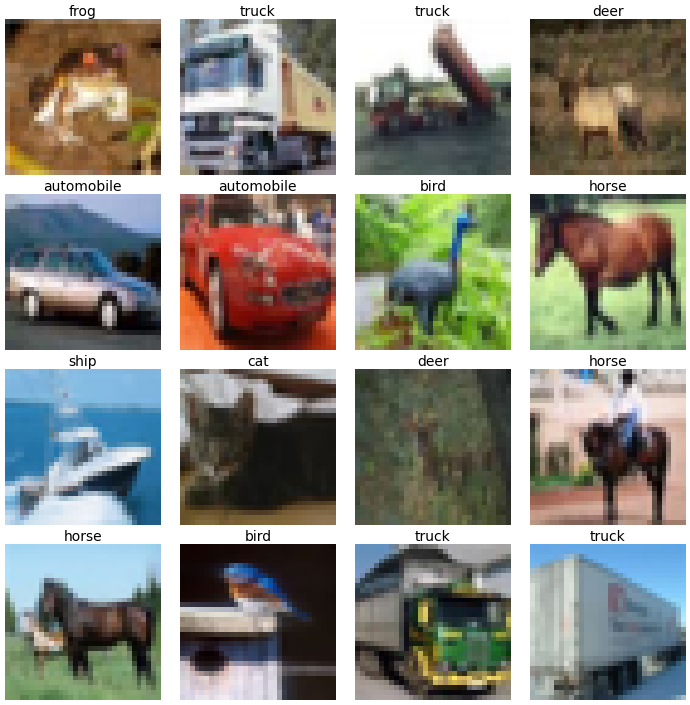

In [3]:

datasets.plot_cifar10_sample(cf10_train)


### Load CNN Model

In [4]:

cf10_cnn = models.CIFAR10_CNN().to(device).to(torch.float64)
cf10_loss_fn = nn.MSELoss() # MSE Loss since it supports one-hot encoding
cf10_lr = config['CIFAR10_learning_rate']
cf10_optimizer = training.get_optimizer(config['CIFAR10_SGD_method'], cf10_cnn.parameters(), cf10_lr)
cf10_scheduler = training.get_scheduler(cf10_optimizer, config['CIFAR10_Scheduler'])

total_params = sum(p.numel() for p in cf10_cnn.parameters())
print("Total Parameters:", total_params)


Total Parameters: 371974



## CNN Training


In [5]:

cf10_train_acc = list()
cf10_test_acc = list()
cf10_train_loss = list()
cf10_test_loss = list()

for t in range(config['CIFAR10_epochs']):
    print(f"Epoch {t+1}, lr {cf10_scheduler.get_last_lr()[0]:0.6f}\n---------------------------------")
    acc, loss = training.cf10_train_loop(cf10_train_wrapped, cf10_cnn, cf10_loss_fn, cf10_optimizer, cf10_scheduler)
    cf10_train_acc.append(acc)
    cf10_train_loss.append(loss)

    print()
    
    acc, loss = training.cf10_test_loop(cf10_test_wrapped, cf10_cnn, cf10_loss_fn)
    cf10_test_acc.append(acc)
    cf10_test_loss.append(loss)

    print()
print("Done!")


Epoch 1, lr 0.001000
---------------------------------
loss: 0.102708 [batch 1 of 13]
loss: 0.098327 [batch 2 of 13]
loss: 0.094764 [batch 3 of 13]
loss: 0.091799 [batch 4 of 13]
loss: 0.090420 [batch 5 of 13]
loss: 0.090734 [batch 6 of 13]
loss: 0.091205 [batch 7 of 13]
loss: 0.090643 [batch 8 of 13]
loss: 0.089985 [batch 9 of 13]
loss: 0.089762 [batch 10 of 13]
loss: 0.089605 [batch 11 of 13]
loss: 0.089475 [batch 12 of 13]
loss: 0.089548 [batch 13 of 13]

Train error:
  Correct:  6165 of 50000
  Accuracy: 12.33%
  Avg loss: 0.092229

Test error:
  Correct:  1635 of 10000
  Accuracy: 16.35%
  Avg loss: 0.089179

Epoch 2, lr 0.000905
---------------------------------
loss: 0.089120 [batch 1 of 13]
loss: 0.089032 [batch 2 of 13]
loss: 0.088842 [batch 3 of 13]
loss: 0.088481 [batch 4 of 13]
loss: 0.088317 [batch 5 of 13]


KeyboardInterrupt: 

## Save model

In [ ]:

save_path = os.path.join(file_dir, 'Saved_Models', config['CIFAR10_saved_filename'])
models.save_CIFAR10_CNN(config['CIFAR10_epochs'], cf10_cnn, cf10_optimizer,\
                        cf10_train_acc, cf10_test_acc, cf10_train_loss, cf10_test_loss,\
                     save_path)
